In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

In [3]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [4]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

# Marginal dependence

&rarr; Relationship between feature $X_i$ and the target $y$ (dependent on the other features)

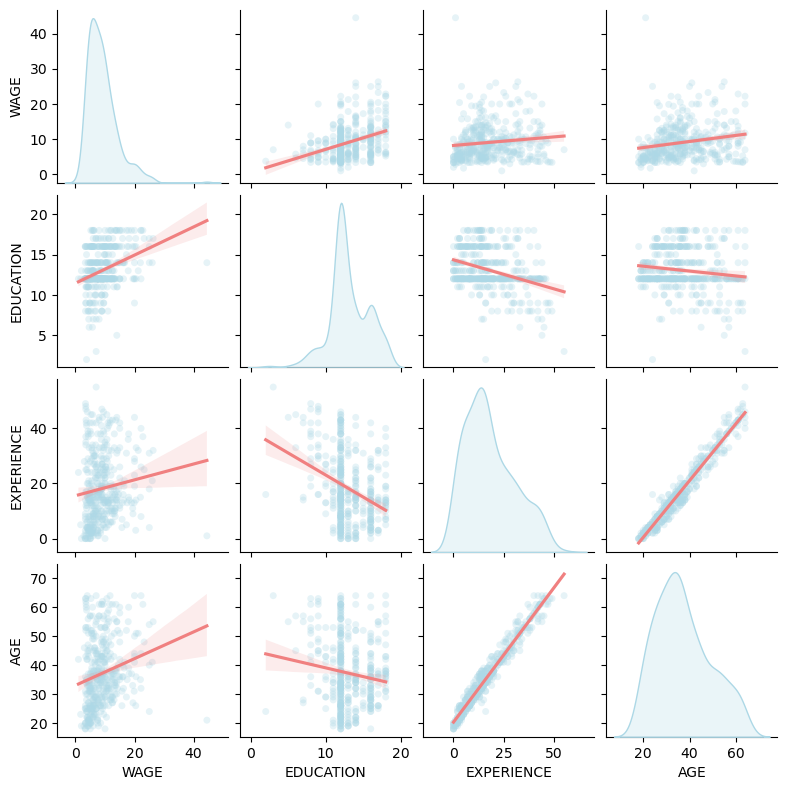

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train = pd.concat([pd.Series(y_train, name=survey.target.name, index=X_train.index), X_train], axis=1)

sns.pairplot(
    train,
    kind='reg',
    diag_kind='kde',
    height=2,
    plot_kws={
        'scatter_kws': {
            'alpha': 0.3,
            'edgecolors': 'none',
            'color': 'lightblue',
            's': 25
        },
        'line_kws': {
            'color': 'lightcoral'
        },
    },
    diag_kws={
        'color': 'lightblue'
    }
)

plt.show()

# Conditional dependence
&rarr; Relationship between feature $X_i$ and the target $y$ assuming that all the other features remain constant

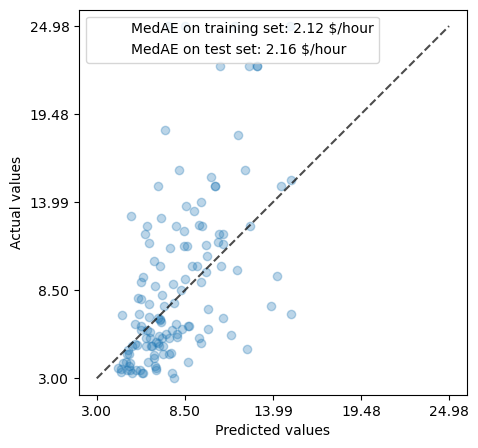

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LassoCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                                                              max_iter=100000)))])

In [51]:
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.pipeline import make_pipeline

# Create a list of columns to be one-hot encoded based on their data types
categorical_cols = survey.data.select_dtypes(include=['category']).columns.tolist()
numerical_cols = survey.data.select_dtypes(include=['number']).columns.tolist()

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_cols),
    (StandardScaler(), numerical_cols), # One-hot vectors should also be scaled
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

alphas = np.logspace(-10, 10, 21) # cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000), func=np.log10, inverse_func=sp.special.exp10) # Take the LOG of target to turn it approximately into a normal distribution
) # RidgeCV -> Better handle cases of multicolinearity

model.fit(X_train, y_train)

from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    'MedAE on training set': f'{mae_train:.2f} $/hour',
    'MedAE on test set': f'{mae_test:.2f} $/hour'
}

fig, ax = plt.subplots(figsize=(5,5))    
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind='actual_vs_predicted', ax=ax, scatter_kwargs={'alpha': 0.3}
)
for name, score in scores.items():
    ax.plot([], [], ' ', label=f'{name}: {score}')
ax.legend()
plt.show()

model

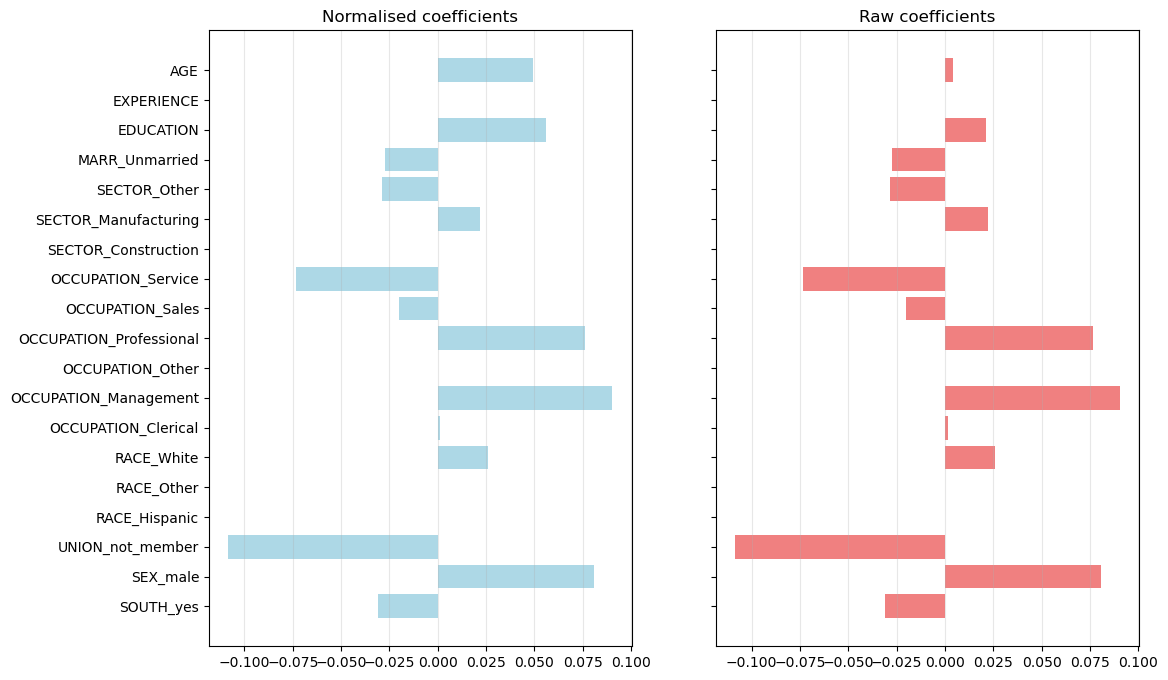

In [50]:
reg = model.named_steps.get('transformedtargetregressor').regressor_
alpha = reg.alpha_
feature_names = model.named_steps.get('columntransformer').get_feature_names_out()
coefs = reg.coef_

# Build dataframe with coefficients indexed by transformed feature names
df_coefs = pd.DataFrame(
    coefs,
    columns=['coef_normalised'],
    index=feature_names
)

enc = OneHotEncoder(drop='if_binary', sparse_output=False)
encoded = enc.fit_transform(X_train.loc[:, categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(categorical_cols), index=X_train.index)

stds = pd.concat([X_train[numerical_cols].std(), pd.Series(1.0, index=encoded_df.columns)])

# Normalised coefficients (consistent with CV computation that multiplies coef * std)
df_coefs['coef_raw'] = df_coefs['coef_normalised'] / stds

def coef_plot(df_coef):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
    ax[0].barh(df_coef.index, df_coef['coef_normalised'], color='lightblue')
    ax[0].grid(axis='x', alpha=0.3)
    ax[0].set_title('Normalised coefficients')
    ax[1].barh(df_coef.index, df_coef['coef_raw'], color='lightcoral')
    ax[1].grid(axis='x', alpha=0.3)
    ax[1].set_title('Raw coefficients')
    plt.show()

coef_plot(df_coefs)

# The regularisation reduces the influence of correlated variables on the model because the weight is shared between the two predicitve variables, so neither alone would have strong weights
# -> Weights obtained with regularisation are more stable
# Lasso -> identifies the correlation between two variables and suppresses one of them for the sake of the prediction (the model chose to suppress them because they bring little additional information on top of the other features)
# -> Unstable selection for correlated features

# Cross-validation
&rarr; Coefficient variability

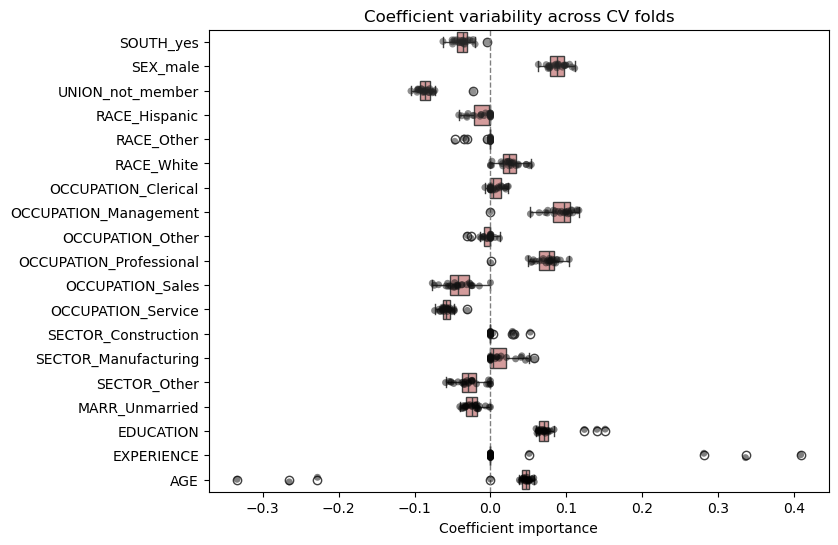

In [48]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2
)

coefs_cv_normalised = pd.DataFrame(
    [
        est.named_steps.get('transformedtargetregressor').regressor_.coef_
        for est, (train_idx, _) in zip(cv_model['estimator'], cv.split(X, y))
    ],
    columns=feature_names
)

def cv_coef_plot(coefs_normalised):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.stripplot(data=coefs_cv_normalised, orient='h', palette='dark:k', alpha=0.5) # To show every points
    sns.boxplot(data=coefs_cv_normalised, orient='h', ax=ax, color='lightcoral', saturation=0.5, whis=1.5) # whisker length ; (IQR = Q1-Q3) -> whisker = k*IQR ; Outliers are outside the "min-max" region (but are not necessarily wrong values)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title('Coefficient variability across CV folds')
    ax.set_xlabel('Coefficient importance')
    plt.show()

cv_coef_plot(coefs_cv_normalised)

## Correlated variables
&rarr; Highlighted by plotting the vairability of two coefficents together

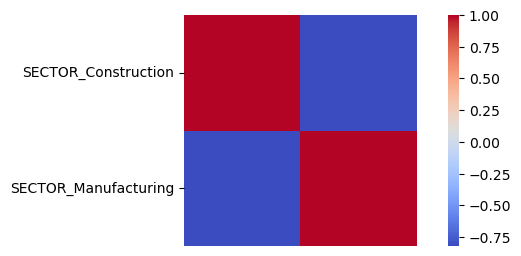

In [43]:
def corr_filter(X_in, corr_tresh=0.9):
    corr_matrix = X_in.corr().abs()
    corr_matrix_filtered = corr_matrix.where(corr_matrix > corr_tresh).dropna(axis=1, thresh=2)
    to_keep = corr_matrix_filtered.columns
    return to_keep

def plot_corr_heatmap(df_plot):
    plt.figure(figsize=(4,3))
    corr = df_plot.corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=True, cbar_kws={'orientation': 'vertical', 'pad': 0.1})
    plt.show()

to_keep = corr_filter(coefs_cv_normalised, 0.8)
coefs_cv_normalised_correlated = coefs_cv_normalised.loc[:, to_keep]

plot_corr_heatmap(coefs_cv_normalised_correlated)

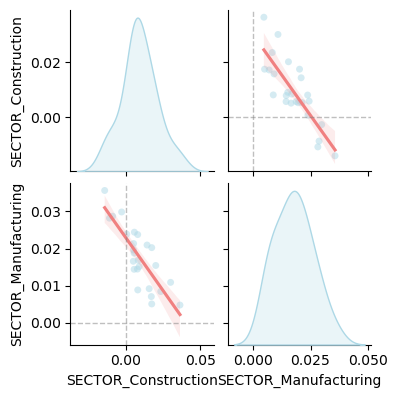

In [44]:
g = sns.pairplot(
    coefs_cv_normalised_correlated,
    kind='reg',
    diag_kind='kde',
    height=2,
    plot_kws={
        'scatter_kws': {
            'alpha': 0.5,
            'edgecolors': 'none',
            'color': 'lightblue',
            's': 25
        },
        'line_kws': {
            'color': 'lightcoral'
        },
    },
    diag_kws={
        'color': 'lightblue'
    }
)

# Add grid lines at x=0 and y=0 for non-diagonal plots
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        if i != j and ax is not None:  # Skip diagonal plots
            ax.axhline(0, color='gray', alpha=0.5, linestyle='--', linewidth=1)
            ax.axvline(0, color='gray', alpha=0.5, linestyle='--', linewidth=1)

plt.show()

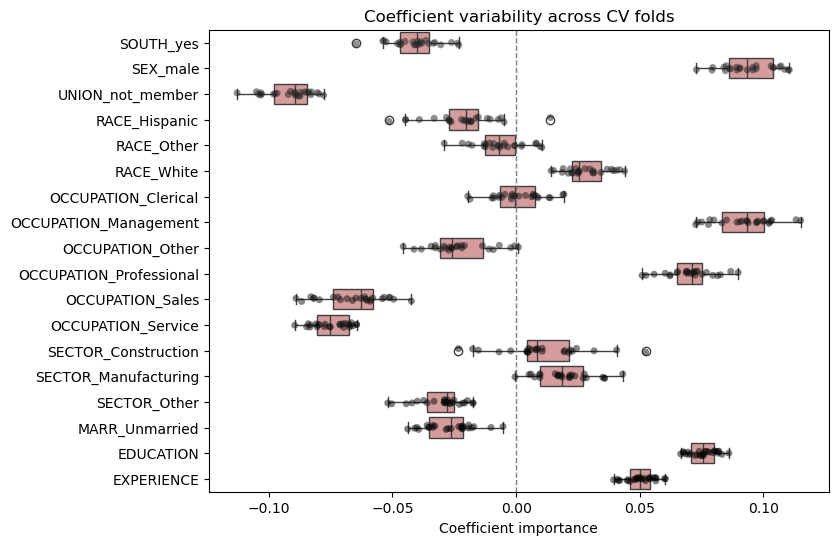

In [45]:
col_to_drop = ["AGE"]
X_dropped = X.drop(columns=col_to_drop)

# Create a list of columns to be one-hot encoded based on their data types
categorical_cols = X_dropped.select_dtypes(include=['category']).columns.tolist()
numerical_cols = X_dropped.select_dtypes(include=['number']).columns.tolist()

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_cols),
    (StandardScaler(), numerical_cols),
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10) # Take the LOG of target to turn it approximately into a normal distribution
)

cv_model = cross_validate(
    model,
    X_dropped,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2
)

# Get feature names from one of the fitted estimators (they reflect the pipeline fitted on the reduced X)
feature_names_cv = cv_model['estimator'][0].named_steps.get('columntransformer').get_feature_names_out()

coefs_cv_normalised = pd.DataFrame(
    [
        est.named_steps.get('transformedtargetregressor').regressor_.coef_
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X_dropped, y))
    ],
    columns=feature_names_cv
)

def cv_coef_plot(df_coefs):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.stripplot(data=df_coefs, orient='h', palette='dark:k', alpha=0.5)  # show every point
    sns.boxplot(data=df_coefs, orient='h', ax=ax, color='lightcoral', saturation=0.5, whis=1.5)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title('Coefficient variability across CV folds')
    ax.set_xlabel('Coefficient importance')
    plt.show()

cv_coef_plot(coefs_cv_normalised)